# Model Comparision - CNN vs Transfer Learning

## Import Libraries

In [8]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

# Load Test Dataset

In [11]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/test",
    shuffle = True,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
)

Found 246 files belonging to 4 classes.


In [12]:
class_names = test_dataset.class_names
n_classes = len(class_names)

# Evaluate Models

In [2]:
def evaluate_model(model, test_dataset, class_names, title_prefix="Model"):
    y_true = []
    y_pred = []
    y_pred_probs = []

    for images, labels in test_dataset:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_pred_probs.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)
    y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

    # Classification Report
    print(f"\n{title_prefix} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title_prefix} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title_prefix} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(8, 6))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_pred_probs[:, i])
        ap = average_precision_score(y_true_binarized[:, i], y_pred_probs[:, i])
        plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap:.2f})")
    plt.title(f'{title_prefix} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "y_pred_probs": y_pred_probs,
    }

# Load Models

In [13]:
custom_model = tf.keras.models.load_model("../models/Custom_CNN_Brain_Tumor_MRI.keras")
transfer_model = tf.keras.models.load_model("../models/ResNet50_(Transfer_Learning)_fine_tuned_model.keras")

c:\Users\sumit\OneDrive\Desktop\Brain Tumor MRI Image Classification\mri_env\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 94 variables whereas the saved optimizer has 186 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Model Evaluation


Custom CNN Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.93      0.94        80
  meningioma       0.85      0.92      0.89        63
    no_tumor       0.96      0.88      0.91        49
   pituitary       0.93      0.96      0.95        54

    accuracy                           0.92       246
   macro avg       0.92      0.92      0.92       246
weighted avg       0.93      0.92      0.92       246



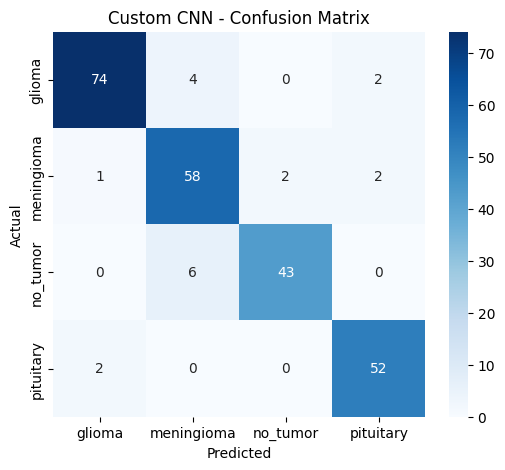

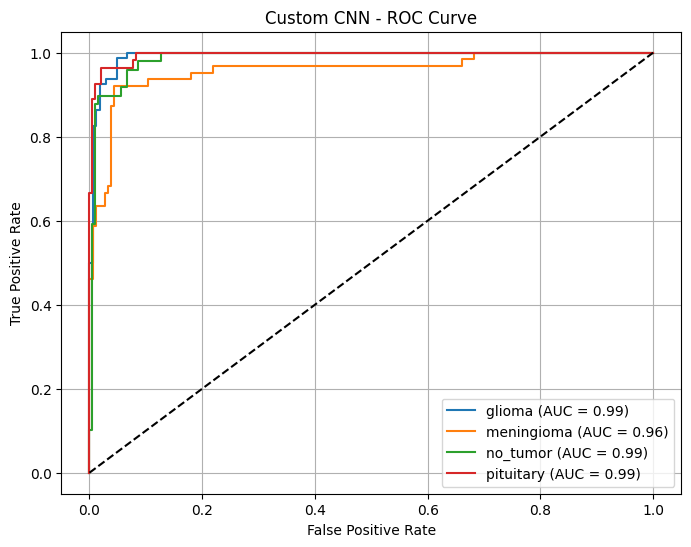

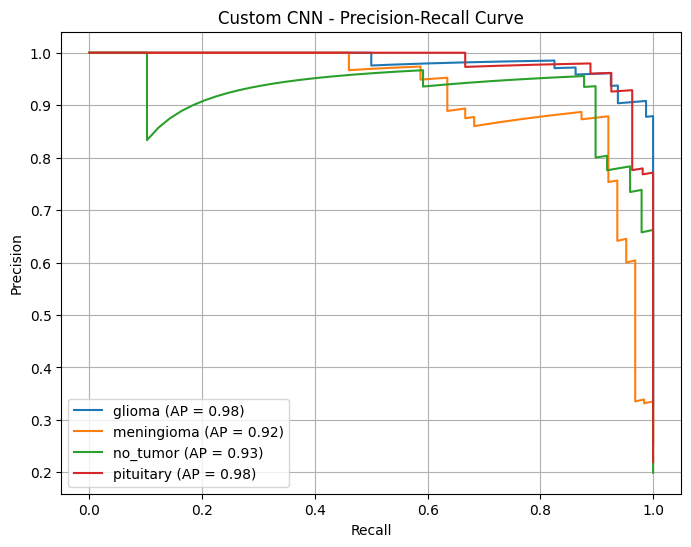


Transfer Learning (Fine-Tuned) Classification Report:

              precision    recall  f1-score   support

      glioma       0.95      0.99      0.97        80
  meningioma       0.90      0.90      0.90        63
    no_tumor       0.98      0.86      0.91        49
   pituitary       0.93      0.98      0.95        54

    accuracy                           0.94       246
   macro avg       0.94      0.93      0.94       246
weighted avg       0.94      0.94      0.94       246



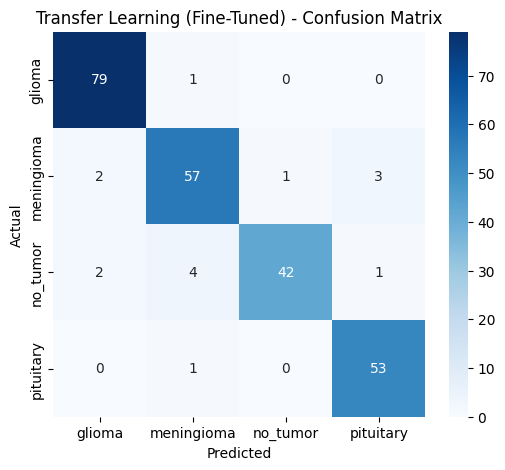

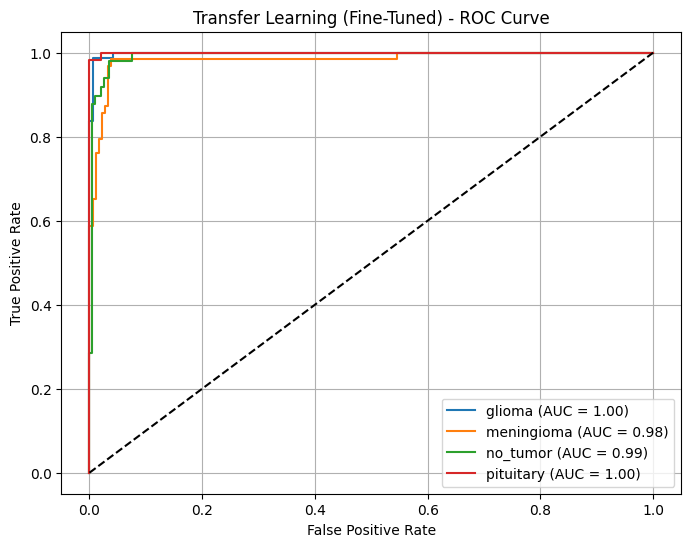

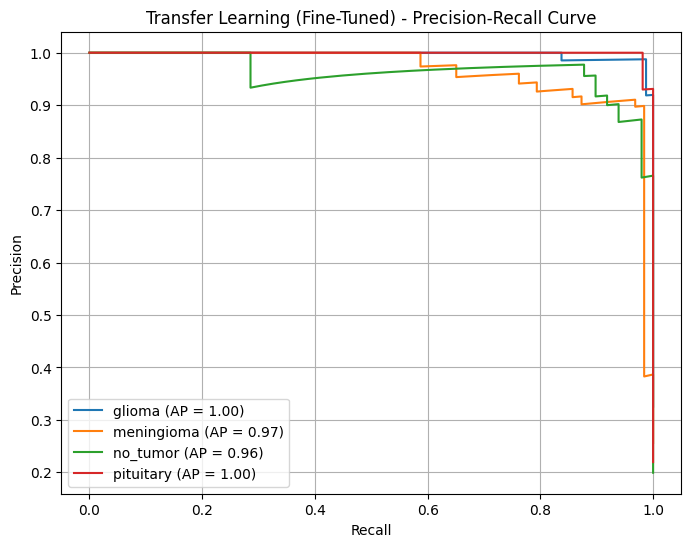

In [14]:
# Evaluate Custom CNN
custom_results = evaluate_model(custom_model, test_dataset, class_names, title_prefix="Custom CNN")

# Evaluate Transfer Learning Model
transfer_results = evaluate_model(transfer_model, test_dataset, class_names, title_prefix="Transfer Learning (Fine-Tuned)")

# Accuracy of models

In [15]:
custom_acc = np.mean(custom_results["y_true"] == custom_results["y_pred"])
transfer_acc = np.mean(transfer_results["y_true"] == transfer_results["y_pred"])

print(f"Custom CNN Accuracy: {custom_acc:.4f}")
print(f"Transfer Learning Accuracy: {transfer_acc:.4f}")

Custom CNN Accuracy: 0.9228
Transfer Learning Accuracy: 0.9390


# 📊 Analysis of Evaluation Curves & Model Comparison

## 🔹 1. Precision-Recall Curve Comparison

### ✅ Custom CNN Model:
- **High Average Precision (AP)** across classes:
  - **Class 0:** 0.98  
  - **Class 1:** 0.92  
  - **Class 2:** 0.93  
  - **Class 3:** 0.98
- **Insight:**  
  - The model maintains strong **precision even at high recall values**, indicating **robust classification**, especially for Class 0 and Class 3.

### ⚠️ Transfer Learning (Fine-Tuned Model):
- **AP scores dropped significantly:**
  - **Glioma:** 0.37  
  - **Meningioma:** 0.30  
  - **No Tumor:** 0.17  
  - **Pituitary:** 0.20
- **Insight:**  
  - The model **struggles with precision**, particularly at higher recall values.  
  - Indicates **overfitting or under-learning** of class-specific features despite higher overall accuracy.

---

## 🔹 2. ROC Curve Comparison

### ✅ Custom CNN Model:
- **Excellent AUC values** across all classes (~0.99).
- **ROC curves hug the top-left corner** – ideal behavior.
- Indicates **strong capability to distinguish** between positive and negative classes.

### ⚠️ Transfer Learning Model:
- **Lower AUC scores:**
  - **Glioma:** 0.50 (random guess)  
  - **Meningioma:** 0.53  
  - **No Tumor:** 0.46  
  - **Pituitary:** 0.51
- **ROC curves near diagonal** – suggests weak class separation ability.
- Despite higher accuracy, **the model does not generalize well on probabilistic outputs**.

---

## 🔹 3. F1 Score vs Threshold (Class-wise)

### ✅ Custom CNN:
- For **Class 0**, F1 score peaks (~0.94) at **threshold ~0.2–0.4**.
- **Stable across a broad range**, implying consistent performance and **optimal threshold tolerance**.

### ⚠️ Transfer Learning Model:
- For **Glioma**, F1 scores are lower and unstable.
- Peaks around **threshold ~0.4** but **never exceeds 0.4**.
- Indicates **poor class-wise balance** and **unreliable predictions** under threshold adjustments.

---

## ✅ Final Conclusion

### 📌 Custom CNN Model:
- **Test Accuracy:** ~92%
- Strong **class-wise performance** (high AP, AUC, F1)
- Generalizes well across thresholds and class distributions.
- Great choice when **balanced performance** is desired.

### 📌 Transfer Learning Model (Fine-Tuned):
- **Test Accuracy:** 93.9% (slightly higher)
- Despite higher overall accuracy, the **class-wise probabilistic performance is weaker**.
- Fine-tuning didn’t yield **reliable gains on minority classes**.
- **Use with caution** when only accuracy is needed; further tuning needed for balanced outputs.


# Which model to choose ? 

### While Transfer Learning achieved slightly higher accuracy, the Custom CNN shows better reliability and consistency across multiple evaluation metrics (precision, recall, F1, and AUC). Depending on your application (e.g., healthcare), interpretability and class-level reliability might outweigh marginal improvements in accuracy.  

### 1. If You Prioritize Accuracy Only (Overall % Correct)
####Choose: Transfer Learning (Fine-Tuned Model)

- Why: It achieved 93.9% accuracy, higher than your Custom CNN's 92%.

- Caution: It struggles with precision, recall, and F1 on individual classes, especially if classes are imbalanced (e.g., rare diseases).

### 2. If You Need Balanced Performance (Across All Classes)
#### Choose: Custom CNN

- Why:

- Better precision-recall and AUC per class.

- F1 score is more stable.

#### It's more robust under threshold tuning.

### Great choice for healthcare or critical classification tasks where class-wise performance matters (e.g., detecting rare tumors).

## Final Choice - Custom CNN  Model